In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from tqdm import tnrange, tqdm_notebook, tqdm

import skorch
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from Lung_dataset import ILDDataset

In [11]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [19]:
NUM_TOTAL = 1982
NUM_TRAIN = 1500
#add path as absolute path for root dir

im_size = 128

lung_dataset_train = ILDDataset(csv_file='../Clean_train_test_dataset/Dataset/train_labels.csv',
                          root_dir='../Clean_train_test_dataset/Dataset/train',
                          mask=True, HU=True, train=True, resize=128)

#add path as absolute path for root dir
lung_dataset_test = ILDDataset(csv_file='../Clean_train_test_dataset/Dataset/test_labels.csv',
                          root_dir='../Clean_train_test_dataset/Dataset/test',
                          mask=True, HU=True, resize=128)

loader_train = DataLoader(lung_dataset_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=64)


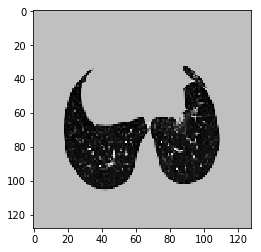

label: 2


In [20]:
#show datasample
sample = lung_dataset_train[12]
plt.imshow(sample[0], cmap='gray')
plt.show()
print("label: " + str(sample[1]))

In [21]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


In [22]:
def get_model(freeze=False):
    """
    Used to fetch model for classification
    """

    num_classes = 3

    model = models.resnet50(pretrained=True)
    model.avgpool = nn.AvgPool2d(1, stride=1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
    if(freeze==True):
        for param in model.parameters():
            param.requires_grad = False
    model.fc = nn.Linear(32768, num_classes)
    
    return model
    

In [23]:
def check_accuracy(loader, model, train=False, val = False):
    predictedStore = []
    solutionStore = []
    if loader.dataset.train and train == True:
        print('Checking accuracy on training set')
    elif val:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            x.unsqueeze_(1)
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            predictedStore.append(preds.view(-1,).cpu().numpy().tolist())
            solutionStore.append(y.data.view(-1,).cpu().numpy().tolist())
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples      
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        
    return acc,predictedStore,solutionStore
 

In [28]:
def train(model, optimizer, epochs=1, overfit=False):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    best_acc = 0;
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            
            #38,16,46
            weights = torch.tensor([1,1, 1], device= device, dtype=dtype)
            x.unsqueeze_(1)
            scores = model(x)
            Loss = nn.CrossEntropyLoss(weight = weights)
            loss = Loss(scores, y)
            
            
            reg = torch.tensor(0.0001, device= device, dtype=dtype)
            l2_reg = torch.tensor(0. , device= device, dtype=dtype)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += reg * l2_reg

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
        print('Epoch %d, loss = %.4f' % (e, loss.item()))
        if(overfit):
            _,predictedStoreTrain,solutionStoreTrain = check_accuracy(loader_train, model, train=True)
        acc,predictedStoreVal,solutionStoreVal = check_accuracy(loader_val, model, val = True)
        if acc > best_acc:
            best_acc = acc
            best_model = model
            predStoreTrain = predictedStoreTrain
            solStoreTrain = solutionStoreTrain
            predStoreVal = predictedStoreVal
            solStoreVal = solutionStoreVal
        print()
    return best_model,predStoreTrain,solStoreTrain,predStoreVal,solStoreVal

In [31]:
model1 = get_model()
optimizer = optim.Adam(model1.parameters(), lr = 0.0001, weight_decay= 1e-4)
best_model,predStoreTrain,solStoreTrain,predStoreVal,solStoreVal = train(model1, optimizer, epochs= 15, overfit=True)

Epoch 0, loss = 0.6297
Checking accuracy on training set
Got 1018 / 1500 correct (67.87)
Checking accuracy on validation set
Got 251 / 482 correct (52.07)

Epoch 1, loss = 0.4595
Checking accuracy on training set
Got 1429 / 1500 correct (95.27)
Checking accuracy on validation set
Got 216 / 482 correct (44.81)

Epoch 2, loss = 0.2878
Checking accuracy on training set
Got 1450 / 1500 correct (96.67)
Checking accuracy on validation set
Got 223 / 482 correct (46.27)

Epoch 3, loss = 0.1692
Checking accuracy on training set
Got 1452 / 1500 correct (96.80)
Checking accuracy on validation set
Got 245 / 482 correct (50.83)

Epoch 4, loss = 0.2791
Checking accuracy on training set
Got 1463 / 1500 correct (97.53)
Checking accuracy on validation set
Got 215 / 482 correct (44.61)

Epoch 5, loss = 0.1705
Checking accuracy on training set
Got 1444 / 1500 correct (96.27)
Checking accuracy on validation set
Got 242 / 482 correct (50.21)

Epoch 6, loss = 0.2232
Checking accuracy on training set
Got 145

In [32]:
#Check Test set
acc,predStoreTest,solStoreTest = check_accuracy(loader_test, best_model)

Checking accuracy on test set


TypeError: 'numpy.float64' object cannot be interpreted as an integer

Confusion matrix, without normalization
[[415   0 292]
 [ 21   0 111]
 [ 58   0 603]]
Confusion matrix, without normalization
[[ 34   0  65]
 [ 19   0  82]
 [ 65   0 217]]


NameError: name 'cnf_matrix3' is not defined

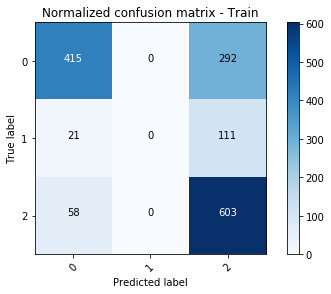

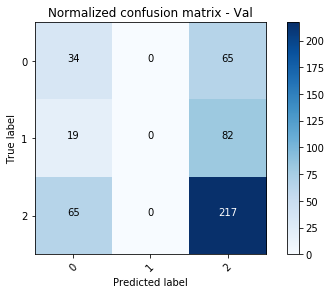

In [34]:
import itertools
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
    
##Actual Plots

y_pred_train = np.concatenate([np.array(i) for i in predStoreTrain])
y_train = np.concatenate([np.array(i) for i in solStoreTrain])

y_pred_val = np.concatenate([np.array(i) for i in predStoreVal]) 
y_val = np.concatenate([np.array(i) for i in solStoreVal])

# y_pred_test = np.concatenate([np.array(i) for i in predStoreTest]) 
# y_test = np.concatenate([np.array(i) for i in solStoreTest])

cnf_matrix1 = confusion_matrix(y_train, y_pred_train)
cnf_matrix2 = confusion_matrix( y_val, y_pred_val)
# cnf_matrix3 = confusion_matrix(y_test, y_pred_test)



class_names = [0,1,2]
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix1, classes=class_names,
                      title='Normalized confusion matrix - Train')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Normalized confusion matrix - Val')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - Test')

plt.show()


#### 